# 호우태풍AnomalyDetection

In [1]:
# from google.colab import files
# from google.colab import drive
import os
import io
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import chisquare
import numpy as np

from datetime import datetime

%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import lime
import shap 

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.getcwd()

'/home/jupyter/code'

In [2]:
data = pd.read_csv('../data/기상호우태풍병합데이터(찐찐최종).csv', index_col = 0)
del data['damage_conv']
del data['typhoon_yn']
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')


In [3]:
del data['Unnamed: 0.1']

In [9]:
tp = data[data['typhoon_yn'] == 1]
print(len(tp))
tp[tp['rain_yn'] == 1]

661


,date,add,ca,ch,avg_ws,mix_ws,max_ws,max_wd,max_ws_wd,max_ins_ws,max_ins_ws_wd,mix_wd,avg.ta,max_ta,min_ta,sum_rn,hr1_max_rn,typhoon_yn,damage_conv,rain_yn
2674,2012-07-17,경기,8.0,16.0,0.9,0.50,3.2,67.5,111.75,5.40,131.05,98.30,24.30,29.20,19.7,0.0,0.0,1.0,7.413754e+03,1.0
2676,2012-07-17,경기,8.0,16.0,0.9,0.50,3.2,67.5,111.75,5.40,131.05,98.30,24.30,29.20,19.7,0.0,0.0,1.0,1.853439e+03,1.0
2683,2012-07-17,서울,8.0,10.0,1.3,0.90,3.2,67.5,79.00,5.70,87.90,88.50,25.30,29.30,21.3,0.0,0.0,1.0,6.178129e+02,1.0
2684,2012-07-17,서울,8.0,10.0,1.3,0.90,3.2,67.5,79.00,5.70,87.90,88.50,25.30,29.30,21.3,0.0,0.0,1.0,1.235626e+03,1.0
2686,2012-07-17,인천,7.0,10.0,1.2,0.90,3.0,90.0,97.20,5.00,101.00,94.70,23.95,28.00,20.4,0.0,0.0,1.0,1.853439e+03,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18417,2015-08-27,부산,3.0,19.0,2.3,2.05,5.2,225.0,206.05,7.75,210.95,228.15,24.40,29.05,20.7,0.0,0.0,1.0,1.344945e+05,1.0
18418,2015-08-27,부산,3.0,19.0,2.3,2.05,5.2,225.0,206.05,7.75,210.95,228.15,24.40,29.05,20.7,0.0,0.0,1.0,3.288000e+05,1.0
18420,2015-08-27,울산,3.0,10.0,2.5,2.50,5.1,225.0,223.30,7.50,225.00,239.90,23.95,29.80,18.9,0.0,0.0,1.0,1.344945e+05,1.0
18421,2015-08-27,울산,3.0,10.0,2.5,2.50,5.1,225.0,223.30,7.50,225.00,239.90,23.95,29.80,18.9,0.0,0.0,1.0,3.288000e+05,1.0


In [10]:
rain_typhoon = data[data['rain_yn'] == 1]

### 개별사용변수 : 평균기온, 운량, 총강수량  
### 풍향합성변수 : -0.488(max_wd) -0.506(max_ws_wd) _0.506(mix_wd) -0.5(max_ins_ws_wd)  
### 풍속합성변수 : -0.51(avg_ws) -0.487(mix_ws) -0.504(max_ws) -0.499(max_ins_ws)

1. train/test 나누기  
2. train/test 시도별로 나누기  
3. date랑 add변수 없애주기  
4. rain_yn 변수는 시도별로 분리해주고 제거
4. train/test 시도별 각 변수 표준화  
5. train/test 풍향&풍속 합성변수 만들어주기  
6. model building

In [4]:
data_rain_yn = data[['date', 'add', 'rain_yn']]
# del data['rain_yn']

In [5]:
train = data.iloc[:62101]
test = data.iloc[62101:]

In [6]:
# Gangwon, Gyeonggi, Gyeongnam, Gyeongbuk, Gwangju, Daegu, Daejeon, Busan, Seoul, Sejong, Ulsan, Incheon, Jeonnam. Jeonbuk, Jeju, Chungnam, Chungbuk
train_Gangwon = train[train['add'] == '강원']
train_Busan = train[train['add'] == '부산']
train_Seoul = train[train['add'] == '서울']

test_Gangwon = test[test['add'] == '강원']
test_Busan = test[test['add'] == '부산']
test_Seoul = test[test['add'] == '서울']

In [7]:
# Gangwon, Gyeonggi, Gyeongnam, Gyeongbuk, Gwangju
# Daegu, Daejeon, Busan, Seoul, Sejong, Ulsan, Incheon, Jeonnam. Jeonbuk, Jeju, Chungnam, Chungbuk
train_Gyeonggi = train[train['add'] == '경기']
train_Gyeongnam = train[train['add'] == '경남']
train_Gyeongbuk = train[train['add'] == '경북']
train_Gwangju = train[train['add'] == '광주']
train_Daegu = train[train['add'] == '대구']
train_Daejeon = train[train['add'] == '대전']
train_Sejong = train[train['add'] == '세종']
train_Ulsan = train[train['add'] == '울산']
train_Incheon = train[train['add'] == '인천']
train_Jeonnam = train[train['add'] == '전남']
train_Jeonbuk = train[train['add'] == '전북']
train_Jeju = train[train['add'] == '제주']
train_Chungnam = train[train['add'] == '충남']
train_Chungbuk = train[train['add'] == '충북']

test_Gyeonggi = test[test['add'] == '경기']
test_Gyeongnam = test[test['add'] == '경남']
test_Gyeongbuk = test[test['add'] == '경북']
test_Gwangju = test[test['add'] == '광주']
test_Daegu = test[test['add'] == '대구']
test_Daejeon = test[test['add'] == '대전']
test_Sejong = test[test['add'] == '세종']
test_Ulsan = test[test['add'] == '울산']
test_Incheon = test[test['add'] == '인천']
test_Jeonnam = test[test['add'] == '전남']
test_Jeonbuk = test[test['add'] == '전북']
test_Jeju = test[test['add'] == '제주']
test_Chungnam = test[test['add'] == '충남']
test_Chungbuk = test[test['add'] == '충북']

In [8]:
# Gangwon, Gyeonggi, Gyeongnam, Gyeongbuk, Gwangju
# Daegu, Daejeon, Busan, Seoul, Sejong, Ulsan, Incheon, Jeonnam. Jeonbuk, Jeju, Chungnam, Chungbuk
train_Gangwon_y = train_Gangwon['rain_yn']
del train_Gangwon['rain_yn']
test_Gangwon_y = test_Gangwon['rain_yn']
del test_Gangwon['rain_yn']
del train_Gangwon['date']
del train_Gangwon['add']
del test_Gangwon['date']
del test_Gangwon['add']

train_Busan_y = train_Busan['rain_yn']
del train_Busan['rain_yn']
test_Busan_y = test_Busan['rain_yn']
del test_Busan['rain_yn']
del train_Busan['date']
del train_Busan['add']
del test_Busan['date']
del test_Busan['add']

train_Seoul_y = train_Seoul['rain_yn']
del train_Seoul['rain_yn']
test_Seoul_y = test_Seoul['rain_yn']
del test_Seoul['rain_yn']
del train_Seoul['date']
del train_Seoul['add']
del test_Seoul['date']
del test_Seoul['add']

In [9]:
# Gyeonggi, Gyeongnam, Gyeongbuk, Gwangju, Daegu, Daejeon,
# Sejong, Ulsan, Incheon, Jeonnam. Jeonbuk, Jeju, Chungnam, Chungbuk
train_Gyeonggi_y = train_Gyeonggi['rain_yn']
del train_Gyeonggi['rain_yn']
test_Gyeonggi_y = test_Gyeonggi['rain_yn']
del test_Gyeonggi['rain_yn']
del train_Gyeonggi['date']
del train_Gyeonggi['add']
del test_Gyeonggi['date']
del test_Gyeonggi['add']

train_Gyeongnam_y = train_Gyeongnam['rain_yn']
del train_Gyeongnam['rain_yn']
test_Gyeongnam_y = test_Gyeongnam['rain_yn']
del test_Gyeongnam['rain_yn']
del train_Gyeongnam['date']
del train_Gyeongnam['add']
del test_Gyeongnam['date']
del test_Gyeongnam['add']

train_Gyeongbuk_y = train_Gyeongbuk['rain_yn']
del train_Gyeongbuk['rain_yn']
test_Gyeongbuk_y = test_Gyeongbuk['rain_yn']
del test_Gyeongbuk['rain_yn']
del train_Gyeongbuk['date']
del train_Gyeongbuk['add']
del test_Gyeongbuk['date']
del test_Gyeongbuk['add']

train_Gwangju_y = train_Gwangju['rain_yn']
del train_Gwangju['rain_yn']
test_Gwangju_y = test_Gwangju['rain_yn']
del test_Gwangju['rain_yn']
del train_Gwangju['date']
del train_Gwangju['add']
del test_Gwangju['date']
del test_Gwangju['add']

train_Daegu_y = train_Daegu['rain_yn']
del train_Daegu['rain_yn']
test_Daegu_y = test_Daegu['rain_yn']
del test_Daegu['rain_yn']
del train_Daegu['date']
del train_Daegu['add']
del test_Daegu['date']
del test_Daegu['add']

train_Daejeon_y = train_Daejeon['rain_yn']
del train_Daejeon['rain_yn']
test_Daejeon_y = test_Daejeon['rain_yn']
del test_Daejeon['rain_yn']
del train_Daejeon['date']
del train_Daejeon['add']
del test_Daejeon['date']
del test_Daejeon['add']

train_Sejong_y = train_Sejong['rain_yn']
del train_Sejong['rain_yn']
test_Sejong_y = test_Sejong['rain_yn']
del test_Sejong['rain_yn']
del train_Sejong['date']
del train_Sejong['add']
del test_Sejong['date']
del test_Sejong['add']

train_Ulsan_y = train_Ulsan['rain_yn']
del train_Ulsan['rain_yn']
test_Ulsan_y = test_Ulsan['rain_yn']
del test_Ulsan['rain_yn']
del train_Ulsan['date']
del train_Ulsan['add']
del test_Ulsan['date']
del test_Ulsan['add']

train_Incheon_y = train_Incheon['rain_yn']
del train_Incheon['rain_yn']
test_Incheon_y = test_Incheon['rain_yn']
del test_Incheon['rain_yn']
del train_Incheon['date']
del train_Incheon['add']
del test_Incheon['date']
del test_Incheon['add']

train_Jeonnam_y = train_Jeonnam['rain_yn']
del train_Jeonnam['rain_yn']
test_Jeonnam_y = test_Jeonnam['rain_yn']
del test_Jeonnam['rain_yn']
del train_Jeonnam['date']
del train_Jeonnam['add']
del test_Jeonnam['date']
del test_Jeonnam['add']

train_Jeonbuk_y = train_Jeonbuk['rain_yn']
del train_Jeonbuk['rain_yn']
test_Jeonbuk_y = test_Jeonbuk['rain_yn']
del test_Jeonbuk['rain_yn']
del train_Jeonbuk['date']
del train_Jeonbuk['add']
del test_Jeonbuk['date']
del test_Jeonbuk['add']

train_Jeju_y = train_Jeju['rain_yn']
del train_Jeju['rain_yn']
test_Jeju_y = test_Jeju['rain_yn']
del test_Jeju['rain_yn']
del train_Jeju['date']
del train_Jeju['add']
del test_Jeju['date']
del test_Jeju['add']

train_Chungnam_y = train_Chungnam['rain_yn']
del train_Chungnam['rain_yn']
test_Chungnam_y = test_Chungnam['rain_yn']
del test_Chungnam['rain_yn']
del train_Chungnam['date']
del train_Chungnam['add']
del test_Chungnam['date']
del test_Chungnam['add']

train_Chungbuk_y = train_Chungbuk['rain_yn']
del train_Chungbuk['rain_yn']
test_Chungbuk_y = test_Chungbuk['rain_yn']
del test_Chungbuk['rain_yn']
del train_Chungbuk['date']
del train_Chungbuk['add']
del test_Chungbuk['date']
del test_Chungbuk['add']

In [10]:
train_Gangwon = (train_Gangwon-train_Gangwon.mean())/train_Gangwon.std()
test_Gangwon = (test_Gangwon-test_Gangwon.mean())/test_Gangwon.std()

train_Busan = (train_Busan-train_Busan.mean())/train_Busan.std()
test_Busan = (test_Busan-test_Busan.mean())/test_Busan.std()

train_Seoul = (train_Seoul-train_Seoul.mean())/train_Seoul.std()
test_Seoul = (test_Seoul-test_Seoul.mean())/test_Seoul.std()

In [11]:
# Gyeonggi, Gyeongnam, Gyeongbuk, Gwangju, Daegu, Daejeon,
# Sejong, Ulsan, Incheon, Jeonnam. Jeonbuk, Jeju, Chungnam, Chungbuk

train_Gyeonggi = (train_Gyeonggi-train_Gyeonggi.mean())/train_Gyeonggi.std()
test_Gyeonggi = (test_Gyeonggi-test_Gyeonggi.mean())/train_Gyeonggi.std()

train_Gyeongnam = (train_Gyeongnam-train_Gyeongnam.mean())/train_Gyeongnam.std()
test_Gyeongnam = (test_Gyeongnam-test_Gyeongnam.mean())/train_Gyeongnam.std()

train_Gyeongbuk = (train_Gyeongbuk-train_Gyeongbuk.mean())/train_Gyeongbuk.std()
test_Gyeongbuk = (test_Gyeongbuk-test_Gyeongbuk.mean())/test_Gyeongbuk.std()

train_Gwangju = (train_Gwangju-train_Gwangju.mean())/train_Gwangju.std()
test_Gwangju = (test_Gwangju-test_Gwangju.mean())/test_Gwangju.std()

train_Daegu = (train_Daegu-train_Daegu.mean())/train_Daegu.std()
test_Daegu = (test_Daegu-test_Daegu.mean())/test_Daegu.std()

train_Daejeon = (train_Daejeon-train_Daejeon.mean())/train_Daejeon.std()
test_Daejeon = (test_Daejeon-test_Daejeon.mean())/test_Daejeon.std()

train_Sejong = (train_Sejong-train_Sejong.mean())/train_Sejong.std()
test_Sejong = (test_Sejong-test_Sejong.mean())/test_Sejong.std()

train_Ulsan = (train_Ulsan-train_Ulsan.mean())/train_Ulsan.std()
test_Ulsan = (test_Ulsan-test_Ulsan.mean())/test_Ulsan.std()

train_Incheon = (train_Incheon-train_Incheon.mean())/train_Incheon.std()
test_Incheon = (test_Incheon-test_Incheon.mean())/test_Incheon.std()

train_Jeonnam = (train_Jeonnam-train_Jeonnam.mean())/train_Jeonnam.std()
test_Jeonnam = (test_Jeonnam-test_Jeonnam.mean())/test_Jeonnam.std()

train_Jeonbuk = (train_Jeonbuk-train_Jeonbuk.mean())/train_Jeonbuk.std()
test_Jeonbuk = (test_Jeonbuk-test_Jeonbuk.mean())/test_Jeonbuk.std()

train_Jeju = (train_Jeju-train_Jeju.mean())/train_Jeju.std()
test_Jeju = (test_Jeju-test_Jeju.mean())/test_Jeju.std()

train_Chungnam = (train_Chungnam-train_Chungnam.mean())/train_Chungnam.std()
test_Chungnam = (test_Chungnam-test_Chungnam.mean())/test_Chungnam.std()

train_Chungbuk = (train_Chungbuk-train_Chungbuk.mean())/train_Chungbuk.std()
test_Chungbuk = (test_Chungbuk-test_Chungbuk.mean())/test_Chungbuk.std()

### 개별사용변수 : 평균기온, 운량, 총강수량  
### 풍향합성변수 : -0.488(max_wd) -0.506(max_ws_wd) -0.506(mix_wd) -0.5(max_ins_ws_wd)  
### 풍속합성변수 : -0.51(avg_ws) -0.487(mix_ws) -0.504(max_ws) -0.499(max_ins_ws)

In [ ]:
# 'max_wd' 'max_ws_wd' 'mix_wd' 'max_ins_ws_wd' 'avg_ws' 'mix_ws' 'max_ws' 'max_ins_ws' 
# 'avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws'

In [64]:
(-1)*(0.488)*train_Gangwon['max_wd'] + (-1)*(0.506)*train_Gangwon['max_ws_wd'] + (-1)*(0.506)*train_Gangwon['mix_wd'] + (-1)*(0.5)*train_Gangwon['max_wd']


0       -2.104921
17      -1.214750
34      -1.914140
51      -1.837161
68      -1.244955
           ...   
62016   -1.273244
62033   -1.136252
62050   -1.472649
62067   -2.794641
62084   -2.559105
Length: 3653, dtype: float64

In [12]:
train_Gangwon['comp_wd'] = (-1)*(0.488)*train_Gangwon['max_wd'] + (-1)*(0.506)*train_Gangwon['max_ws_wd'] + (-1)*(0.506)*train_Gangwon['mix_wd'] + (-1)*(0.5)*train_Gangwon['max_wd']
test_Gangwon['comp_wd'] = (-1)*(0.488)*test_Gangwon['max_wd'] + (-1)*(0.506)*test_Gangwon['max_ws_wd'] + (-1)*(0.506)*test_Gangwon['mix_wd'] + (-1)*(0.5)*test_Gangwon['max_wd']
train_Gangwon['comp_ws'] = (-1)*(0.51)*train_Gangwon['avg_ws'] + (-1)*(0.487)*train_Gangwon['mix_ws'] + (-1)*(0.504)*train_Gangwon['max_ws'] + (-1)*(0.499)*train_Gangwon['max_ins_ws']
test_Gangwon['comp_ws'] = (-1)*(0.51)*test_Gangwon['max_ws'] + (-1)*(0.487)*test_Gangwon['mix_ws'] + (-1)*(0.504)*test_Gangwon['max_ws'] + (-1)*(0.499)*test_Gangwon['max_ins_ws']

train_Busan['comp_wd'] = (-1)*(0.488)*train_Busan['max_wd'] + (-1)*(0.506)*train_Busan['max_ws_wd'] + (-1)*(0.506)*train_Busan['mix_wd'] + (-1)*(0.5)*train_Busan['max_wd']
test_Busan['comp_wd'] = (-1)*(0.488)*test_Busan['max_wd'] + (-1)*(0.506)*test_Busan['max_ws_wd'] + (-1)*(0.506)*test_Busan['mix_wd'] + (-1)*(0.5)*test_Busan['max_wd']
train_Busan['comp_ws'] = (-1)*(0.51)*train_Busan['avg_ws'] + (-1)*(0.487)*train_Busan['mix_ws'] + (-1)*(0.504)*train_Busan['max_ws'] + (-1)*(0.499)*train_Busan['max_ins_ws']
test_Busan['comp_ws'] = (-1)*(0.51)*test_Busan['avg_ws'] + (-1)*(0.487)*test_Busan['mix_ws'] + (-1)*(0.504)*test_Busan['max_ws'] + (-1)*(0.499)*test_Busan['max_ins_ws']

train_Seoul['comp_wd'] = (-1)*(0.488)*train_Seoul['max_wd'] + (-1)*(0.506)*train_Seoul['max_ws_wd'] + (-1)*(0.506)*train_Seoul['mix_wd'] + (-1)*(0.5)*train_Seoul['max_wd']
test_Seoul['comp_wd'] = (-1)*(0.488)*test_Seoul['max_wd'] + (-1)*(0.506)*test_Seoul['max_ws_wd'] + (-1)*(0.506)*test_Seoul['mix_wd'] + (-1)*(0.5)*test_Seoul['max_wd']
train_Seoul['comp_ws'] = (-1)*(0.51)*train_Seoul['avg_ws'] + (-1)*(0.487)*train_Seoul['mix_ws'] + (-1)*(0.504)*train_Seoul['max_ws'] + (-1)*(0.499)*train_Seoul['max_ins_ws']
test_Seoul['comp_ws'] = (-1)*(0.51)*test_Seoul['avg_ws'] + (-1)*(0.487)*test_Seoul['mix_ws'] + (-1)*(0.504)*test_Seoul['max_ws'] + (-1)*(0.499)*test_Seoul['max_ins_ws']



In [13]:
# Gyeonggi, Gyeongnam, Gyeongbuk, Gwangju, Daegu, Daejeon,
# Sejong, Ulsan, Incheon, Jeonnam. Jeonbuk, Jeju, Chungnam, Chungbuk

train_Gyeonggi['comp_wd'] = (-1)*(0.488)*train_Gyeonggi['max_wd'] + (-1)*(0.506)*train_Gyeonggi['max_ws_wd'] + (-1)*(0.506)*train_Gyeonggi['mix_wd'] + (-1)*(0.5)*train_Gyeonggi['max_wd']
test_Gyeonggi['comp_wd'] = (-1)*(0.488)*test_Gyeonggi['max_wd'] + (-1)*(0.506)*test_Gyeonggi['max_ws_wd'] + (-1)*(0.506)*test_Gyeonggi['mix_wd'] + (-1)*(0.5)*test_Gyeonggi['max_wd']
train_Gyeonggi['comp_ws'] = (-1)*(0.51)*train_Gyeonggi['avg_ws'] + (-1)*(0.487)*train_Gyeonggi['mix_ws'] + (-1)*(0.504)*train_Gyeonggi['max_ws'] + (-1)*(0.499)*train_Gyeonggi['max_ins_ws']
test_Gyeonggi['comp_ws'] = (-1)*(0.51)*test_Gyeonggi['max_ws'] + (-1)*(0.487)*test_Gyeonggi['mix_ws'] + (-1)*(0.504)*test_Gyeonggi['max_ws'] + (-1)*(0.499)*test_Gyeonggi['max_ins_ws']

train_Gyeongnam['comp_wd'] = (-1)*(0.488)*train_Gyeongnam['max_wd'] + (-1)*(0.506)*train_Gyeongnam['max_ws_wd'] + (-1)*(0.506)*train_Gyeongnam['mix_wd'] + (-1)*(0.5)*train_Gyeongnam['max_wd']
test_Gyeongnam['comp_wd'] = (-1)*(0.488)*test_Gyeongnam['max_wd'] + (-1)*(0.506)*test_Gyeongnam['max_ws_wd'] + (-1)*(0.506)*test_Gyeongnam['mix_wd'] + (-1)*(0.5)*test_Gyeongnam['max_wd']
train_Gyeongnam['comp_ws'] = (-1)*(0.51)*train_Gyeongnam['avg_ws'] + (-1)*(0.487)*train_Gyeongnam['mix_ws'] + (-1)*(0.504)*train_Gyeongnam['max_ws'] + (-1)*(0.499)*train_Gyeongnam['max_ins_ws']
test_Gyeongnam['comp_ws'] = (-1)*(0.51)*test_Gyeongnam['avg_ws'] + (-1)*(0.487)*test_Gyeongnam['mix_ws'] + (-1)*(0.504)*test_Gyeongnam['max_ws'] + (-1)*(0.499)*test_Gyeongnam['max_ins_ws']

train_Gyeongbuk['comp_wd'] = (-1)*(0.488)*train_Gyeongbuk['max_wd'] + (-1)*(0.506)*train_Gyeongbuk['max_ws_wd'] + (-1)*(0.506)*train_Gyeongbuk['mix_wd'] + (-1)*(0.5)*train_Gyeongbuk['max_wd']
test_Gyeongbuk['comp_wd'] = (-1)*(0.488)*test_Gyeongbuk['max_wd'] + (-1)*(0.506)*test_Gyeongbuk['max_ws_wd'] + (-1)*(0.506)*test_Gyeongbuk['mix_wd'] + (-1)*(0.5)*test_Gyeongbuk['max_wd']
train_Gyeongbuk['comp_ws'] = (-1)*(0.51)*train_Gyeongbuk['avg_ws'] + (-1)*(0.487)*train_Gyeongbuk['mix_ws'] + (-1)*(0.504)*train_Gyeongbuk['max_ws'] + (-1)*(0.499)*train_Gyeongbuk['max_ins_ws']
test_Gyeongbuk['comp_ws'] = (-1)*(0.51)*test_Gyeongbuk['avg_ws'] + (-1)*(0.487)*test_Gyeongbuk['mix_ws'] + (-1)*(0.504)*test_Gyeongbuk['max_ws'] + (-1)*(0.499)*test_Gyeongbuk['max_ins_ws']

train_Gwangju['comp_wd'] = (-1)*(0.488)*train_Gwangju['max_wd'] + (-1)*(0.506)*train_Gwangju['max_ws_wd'] + (-1)*(0.506)*train_Gwangju['mix_wd'] + (-1)*(0.5)*train_Gwangju['max_wd']
test_Gwangju['comp_wd'] = (-1)*(0.488)*test_Gwangju['max_wd'] + (-1)*(0.506)*test_Gwangju['max_ws_wd'] + (-1)*(0.506)*test_Gwangju['mix_wd'] + (-1)*(0.5)*test_Gwangju['max_wd']
train_Gwangju['comp_ws'] = (-1)*(0.51)*train_Gwangju['avg_ws'] + (-1)*(0.487)*train_Gwangju['mix_ws'] + (-1)*(0.504)*train_Gwangju['max_ws'] + (-1)*(0.499)*train_Gwangju['max_ins_ws']
test_Gwangju['comp_ws'] = (-1)*(0.51)*test_Gwangju['max_ws'] + (-1)*(0.487)*test_Gwangju['mix_ws'] + (-1)*(0.504)*test_Gwangju['max_ws'] + (-1)*(0.499)*test_Gwangju['max_ins_ws']

train_Daegu['comp_wd'] = (-1)*(0.488)*train_Daegu['max_wd'] + (-1)*(0.506)*train_Daegu['max_ws_wd'] + (-1)*(0.506)*train_Daegu['mix_wd'] + (-1)*(0.5)*train_Daegu['max_wd']
test_Daegu['comp_wd'] = (-1)*(0.488)*test_Daegu['max_wd'] + (-1)*(0.506)*test_Daegu['max_ws_wd'] + (-1)*(0.506)*test_Daegu['mix_wd'] + (-1)*(0.5)*test_Daegu['max_wd']
train_Daegu['comp_ws'] = (-1)*(0.51)*train_Daegu['avg_ws'] + (-1)*(0.487)*train_Daegu['mix_ws'] + (-1)*(0.504)*train_Daegu['max_ws'] + (-1)*(0.499)*train_Daegu['max_ins_ws']
test_Daegu['comp_ws'] = (-1)*(0.51)*test_Daegu['avg_ws'] + (-1)*(0.487)*test_Daegu['mix_ws'] + (-1)*(0.504)*test_Daegu['max_ws'] + (-1)*(0.499)*test_Daegu['max_ins_ws']

train_Daejeon['comp_wd'] = (-1)*(0.488)*train_Daejeon['max_wd'] + (-1)*(0.506)*train_Daejeon['max_ws_wd'] + (-1)*(0.506)*train_Daejeon['mix_wd'] + (-1)*(0.5)*train_Daejeon['max_wd']
test_Daejeon['comp_wd'] = (-1)*(0.488)*test_Daejeon['max_wd'] + (-1)*(0.506)*test_Daejeon['max_ws_wd'] + (-1)*(0.506)*test_Daejeon['mix_wd'] + (-1)*(0.5)*test_Daejeon['max_wd']
train_Daejeon['comp_ws'] = (-1)*(0.51)*train_Daejeon['avg_ws'] + (-1)*(0.487)*train_Daejeon['mix_ws'] + (-1)*(0.504)*train_Daejeon['max_ws'] + (-1)*(0.499)*train_Daejeon['max_ins_ws']
test_Daejeon['comp_ws'] = (-1)*(0.51)*test_Daejeon['avg_ws'] + (-1)*(0.487)*test_Daejeon['mix_ws'] + (-1)*(0.504)*test_Daejeon['max_ws'] + (-1)*(0.499)*test_Daejeon['max_ins_ws']

train_Sejong['comp_wd'] = (-1)*(0.488)*train_Sejong['max_wd'] + (-1)*(0.506)*train_Sejong['max_ws_wd'] + (-1)*(0.506)*train_Sejong['mix_wd'] + (-1)*(0.5)*train_Sejong['max_wd']
test_Sejong['comp_wd'] = (-1)*(0.488)*test_Sejong['max_wd'] + (-1)*(0.506)*test_Sejong['max_ws_wd'] + (-1)*(0.506)*test_Sejong['mix_wd'] + (-1)*(0.5)*test_Sejong['max_wd']
train_Sejong['comp_ws'] = (-1)*(0.51)*train_Sejong['avg_ws'] + (-1)*(0.487)*train_Sejong['mix_ws'] + (-1)*(0.504)*train_Sejong['max_ws'] + (-1)*(0.499)*train_Sejong['max_ins_ws']
test_Sejong['comp_ws'] = (-1)*(0.51)*test_Sejong['max_ws'] + (-1)*(0.487)*test_Sejong['mix_ws'] + (-1)*(0.504)*test_Sejong['max_ws'] + (-1)*(0.499)*test_Sejong['max_ins_ws']

train_Ulsan['comp_wd'] = (-1)*(0.488)*train_Ulsan['max_wd'] + (-1)*(0.506)*train_Ulsan['max_ws_wd'] + (-1)*(0.506)*train_Ulsan['mix_wd'] + (-1)*(0.5)*train_Ulsan['max_wd']
test_Ulsan['comp_wd'] = (-1)*(0.488)*test_Ulsan['max_wd'] + (-1)*(0.506)*test_Ulsan['max_ws_wd'] + (-1)*(0.506)*test_Ulsan['mix_wd'] + (-1)*(0.5)*test_Ulsan['max_wd']
train_Ulsan['comp_ws'] = (-1)*(0.51)*train_Ulsan['avg_ws'] + (-1)*(0.487)*train_Ulsan['mix_ws'] + (-1)*(0.504)*train_Ulsan['max_ws'] + (-1)*(0.499)*train_Ulsan['max_ins_ws']
test_Ulsan['comp_ws'] = (-1)*(0.51)*test_Ulsan['avg_ws'] + (-1)*(0.487)*test_Ulsan['mix_ws'] + (-1)*(0.504)*test_Ulsan['max_ws'] + (-1)*(0.499)*test_Ulsan['max_ins_ws']

train_Incheon['comp_wd'] = (-1)*(0.488)*train_Incheon['max_wd'] + (-1)*(0.506)*train_Incheon['max_ws_wd'] + (-1)*(0.506)*train_Incheon['mix_wd'] + (-1)*(0.5)*train_Incheon['max_wd']
test_Incheon['comp_wd'] = (-1)*(0.488)*test_Incheon['max_wd'] + (-1)*(0.506)*test_Incheon['max_ws_wd'] + (-1)*(0.506)*test_Incheon['mix_wd'] + (-1)*(0.5)*test_Incheon['max_wd']
train_Incheon['comp_ws'] = (-1)*(0.51)*train_Incheon['avg_ws'] + (-1)*(0.487)*train_Incheon['mix_ws'] + (-1)*(0.504)*train_Incheon['max_ws'] + (-1)*(0.499)*train_Incheon['max_ins_ws']
test_Incheon['comp_ws'] = (-1)*(0.51)*test_Incheon['avg_ws'] + (-1)*(0.487)*test_Incheon['mix_ws'] + (-1)*(0.504)*test_Incheon['max_ws'] + (-1)*(0.499)*test_Incheon['max_ins_ws']

train_Jeonnam['comp_wd'] = (-1)*(0.488)*train_Jeonnam['max_wd'] + (-1)*(0.506)*train_Jeonnam['max_ws_wd'] + (-1)*(0.506)*train_Jeonnam['mix_wd'] + (-1)*(0.5)*train_Jeonnam['max_wd']
test_Jeonnam['comp_wd'] = (-1)*(0.488)*test_Jeonnam['max_wd'] + (-1)*(0.506)*test_Jeonnam['max_ws_wd'] + (-1)*(0.506)*test_Jeonnam['mix_wd'] + (-1)*(0.5)*test_Jeonnam['max_wd']
train_Jeonnam['comp_ws'] = (-1)*(0.51)*train_Jeonnam['avg_ws'] + (-1)*(0.487)*train_Jeonnam['mix_ws'] + (-1)*(0.504)*train_Jeonnam['max_ws'] + (-1)*(0.499)*train_Jeonnam['max_ins_ws']
test_Jeonnam['comp_ws'] = (-1)*(0.51)*test_Jeonnam['max_ws'] + (-1)*(0.487)*test_Jeonnam['mix_ws'] + (-1)*(0.504)*test_Jeonnam['max_ws'] + (-1)*(0.499)*test_Jeonnam['max_ins_ws']

train_Jeonbuk['comp_wd'] = (-1)*(0.488)*train_Jeonbuk['max_wd'] + (-1)*(0.506)*train_Jeonbuk['max_ws_wd'] + (-1)*(0.506)*train_Jeonbuk['mix_wd'] + (-1)*(0.5)*train_Jeonbuk['max_wd']
test_Jeonbuk['comp_wd'] = (-1)*(0.488)*test_Jeonbuk['max_wd'] + (-1)*(0.506)*test_Jeonbuk['max_ws_wd'] + (-1)*(0.506)*test_Jeonbuk['mix_wd'] + (-1)*(0.5)*test_Jeonbuk['max_wd']
train_Jeonbuk['comp_ws'] = (-1)*(0.51)*train_Jeonbuk['avg_ws'] + (-1)*(0.487)*train_Jeonbuk['mix_ws'] + (-1)*(0.504)*train_Jeonbuk['max_ws'] + (-1)*(0.499)*train_Jeonbuk['max_ins_ws']
test_Jeonbuk['comp_ws'] = (-1)*(0.51)*test_Jeonbuk['avg_ws'] + (-1)*(0.487)*test_Jeonbuk['mix_ws'] + (-1)*(0.504)*test_Jeonbuk['max_ws'] + (-1)*(0.499)*test_Jeonbuk['max_ins_ws']

train_Jeju['comp_wd'] = (-1)*(0.488)*train_Jeju['max_wd'] + (-1)*(0.506)*train_Jeju['max_ws_wd'] + (-1)*(0.506)*train_Jeju['mix_wd'] + (-1)*(0.5)*train_Jeju['max_wd']
test_Jeju['comp_wd'] = (-1)*(0.488)*test_Jeju['max_wd'] + (-1)*(0.506)*test_Jeju['max_ws_wd'] + (-1)*(0.506)*test_Jeju['mix_wd'] + (-1)*(0.5)*test_Jeju['max_wd']
train_Jeju['comp_ws'] = (-1)*(0.51)*train_Jeju['avg_ws'] + (-1)*(0.487)*train_Jeju['mix_ws'] + (-1)*(0.504)*train_Jeju['max_ws'] + (-1)*(0.499)*train_Jeju['max_ins_ws']
test_Jeju['comp_ws'] = (-1)*(0.51)*test_Jeju['avg_ws'] + (-1)*(0.487)*test_Jeju['mix_ws'] + (-1)*(0.504)*test_Jeju['max_ws'] + (-1)*(0.499)*test_Jeju['max_ins_ws']

train_Chungnam['comp_wd'] = (-1)*(0.488)*train_Chungnam['max_wd'] + (-1)*(0.506)*train_Chungnam['max_ws_wd'] + (-1)*(0.506)*train_Chungnam['mix_wd'] + (-1)*(0.5)*train_Chungnam['max_wd']
test_Chungnam['comp_wd'] = (-1)*(0.488)*test_Chungnam['max_wd'] + (-1)*(0.506)*test_Chungnam['max_ws_wd'] + (-1)*(0.506)*test_Chungnam['mix_wd'] + (-1)*(0.5)*test_Chungnam['max_wd']
train_Chungnam['comp_ws'] = (-1)*(0.51)*train_Chungnam['avg_ws'] + (-1)*(0.487)*train_Chungnam['mix_ws'] + (-1)*(0.504)*train_Chungnam['max_ws'] + (-1)*(0.499)*train_Chungnam['max_ins_ws']
test_Chungnam['comp_ws'] = (-1)*(0.51)*test_Chungnam['avg_ws'] + (-1)*(0.487)*test_Chungnam['mix_ws'] + (-1)*(0.504)*test_Chungnam['max_ws'] + (-1)*(0.499)*test_Chungnam['max_ins_ws']

train_Chungbuk['comp_wd'] = (-1)*(0.488)*train_Chungbuk['max_wd'] + (-1)*(0.506)*train_Chungbuk['max_ws_wd'] + (-1)*(0.506)*train_Chungbuk['mix_wd'] + (-1)*(0.5)*train_Chungbuk['max_wd']
test_Chungbuk['comp_wd'] = (-1)*(0.488)*test_Chungbuk['max_wd'] + (-1)*(0.506)*test_Chungbuk['max_ws_wd'] + (-1)*(0.506)*test_Chungbuk['mix_wd'] + (-1)*(0.5)*test_Chungbuk['max_wd']
train_Chungbuk['comp_ws'] = (-1)*(0.51)*train_Chungbuk['avg_ws'] + (-1)*(0.487)*train_Chungbuk['mix_ws'] + (-1)*(0.504)*train_Chungbuk['max_ws'] + (-1)*(0.499)*train_Chungbuk['max_ins_ws']
test_Chungbuk['comp_ws'] = (-1)*(0.51)*test_Chungbuk['avg_ws'] + (-1)*(0.487)*test_Chungbuk['mix_ws'] + (-1)*(0.504)*test_Chungbuk['max_ws'] + (-1)*(0.499)*test_Chungbuk['max_ins_ws']



In [15]:
train_Gangwon

,ca,avg_ws,mix_ws,max_ws,max_ws_wd,max_wd,max_ins_ws,max_ins_ws_wd,mix_wd,avg_ta,sum_rn,comp_wd,comp_ws
0,0.330668,0.343017,0.488759,0.637842,1.143570,1.004019,0.630241,1.349583,1.055937,-1.400564,-0.320777,-2.104921,-1.048927
17,-0.696407,-0.661066,-0.644466,-0.638462,0.584835,0.573534,-0.812204,0.521952,0.695993,-1.689726,-0.329270,-1.214750,1.378073
34,-0.035748,0.343017,0.326870,0.364349,1.026218,1.004019,0.586530,1.107180,0.796251,-1.622255,-0.330533,-1.914140,-0.810434
51,-1.154427,0.845058,0.974426,0.273184,0.957909,1.004019,0.411688,0.999831,0.712429,-1.805391,-0.335123,-1.837161,-1.248643
68,-1.741526,0.008322,-0.158798,-0.000310,0.726708,0.573534,-0.112837,0.473472,0.613814,-1.969250,-0.334536,-1.244955,0.129552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62016,-1.137376,0.845058,0.650648,0.820172,0.700435,0.573534,1.067345,0.798983,0.695993,-1.959611,-0.333976,-1.273244,-1.693817
62033,-0.530350,-0.493719,-0.158798,-0.547297,0.681169,0.573534,-0.025416,0.717605,0.444525,-1.487313,-0.335123,-1.136252,0.617652
62050,0.338301,1.347100,1.298205,1.093665,0.987685,0.573534,1.591871,0.960008,0.802826,-1.111402,-0.318137,-1.472649,-2.664797
62067,-1.464731,2.351183,2.431430,1.549488,1.514893,1.434504,2.072685,1.420572,1.207146,-1.439119,-0.335123,-2.794641,-4.198421


In [14]:
# 'avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws'
train_Gangwon = train_Gangwon[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Gangwon = test_Gangwon[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Seoul = train_Seoul[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Seoul = test_Seoul[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Busan = train_Busan[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Busan = test_Busan[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

In [15]:
# Gyeonggi, Gyeongnam, Gyeongbuk, Gwangju, Daegu, Daejeon,
# Sejong, Ulsan, Incheon, Jeonnam. Jeonbuk, Jeju, Chungnam, Chungbuk

train_Gyeonggi = train_Gyeonggi[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Gyeonggi = test_Gyeonggi[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Gyeongnam = train_Gyeongnam[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Gyeongnam = test_Gyeongnam[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Gyeongbuk = train_Gyeongbuk[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Gyeongbuk = test_Gyeongbuk[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Gwangju = train_Gwangju[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Gwangju = test_Gwangju[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Daegu = train_Daegu[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Daegu = test_Daegu[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Daejeon = train_Daejeon[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Daejeon = test_Daejeon[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Sejong = train_Sejong[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Sejong = test_Sejong[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Ulsan = train_Ulsan[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Ulsan = test_Ulsan[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Incheon = train_Incheon[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Incheon = test_Incheon[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Jeonnam = train_Jeonnam[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Jeonnam = test_Jeonnam[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Jeonbuk = train_Jeonbuk[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Jeonbuk = test_Jeonbuk[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Jeju = train_Jeju[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Jeju = test_Jeju[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Chungnam = train_Chungnam[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Chungnam = test_Chungnam[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]

train_Chungbuk = train_Chungbuk[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]
test_Chungbuk = test_Chungbuk[['avg_ta', 'ca', 'sum_rn', 'comp_wd', 'comp_ws']]


In [84]:
train_Gangwon.to_csv('../data/train_Gangwon.csv')
test_Gangwon.to_csv('../data/test_Gangwon.csv')
train_Gangwon_y.to_csv('../data/train_Gangwon_y.csv')
test_Gangwon_y.to_csv('../data/test_Gangwon_y.csv')

train_Seoul.to_csv('../data/train_Seoul.csv')
test_Seoul.to_csv('../data/test_Seoul.csv')
train_Seoul_y.to_csv('../data/train_Seoul_y.csv')
test_Seoul_y.to_csv('../data/test_Seoul_y.csv')

train_Busan.to_csv('../data/train_Busan.csv')
test_Busan.to_csv('../data/test_Busan.csv')
train_Busan_y.to_csv('../data/train_Busan_y.csv')
test_Busan_y.to_csv('../data/test_Busan_y.csv')

# model building

In [16]:
def objective_if(trial):
    # global X_train
    # global X_test
    
    params={
        
        'n_estimators' :trial.suggest_int('n_estimators', 20, 200),
        'max_samples' : trial.suggest_uniform('max_samples', 0.15, 0.8),
        'contamination' : trial.suggest_loguniform('contamination', 0.001, 0.04),
        'max_features' : trial.suggest_uniform('max_features', 0.3, 0.75),
        'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]) }
    
    # 아래 잘못된 변수명 있으면 고치기 
    
    clf = IsolationForest(**params)
    clf.fit(X_train) 
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    y_pred_test = pd.DataFrame(y_pred_test)
    y_pred = []
    
    
    for i in range(len(y_pred_test)):
        if y_pred_test.iloc[i,0] == 1 :
            y_pred_test.iloc[i,0] = 0
        else:
            y_pred_test.iloc[i,0] = 1
        
    f1 = f1_score(y_test, y_pred_test,average='micro')
    
    return f1

## 강원

In [75]:
X_train, X_test, y_train, y_test = train_test_split(train_Gangwon, train_Gangwon_y, test_size=0.2,stratify=train_Gangwon_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-12 06:16:40,238] A new study created in memory with name: no-name-507307bc-7a56-4b07-93ca-c884ead3e463
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

Trial 65 finished with value: 0.9849521203830369 and parameters: {'n_estimators': 99, 'max_samples': 0.4554247719869113, 'contamination': 0.002718415203890353, 'max_features': 0.5302883547092881, 'bootstrap': False}. Best is trial 65 with value: 0.9849521203830369.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_Gangwon, train_Gangwon_y, test_size=0.2,stratify=train_Gangwon_y, random_state=1111)


In [28]:
clf = IsolationForest(n_estimators=99, max_samples=0.455, contamination = 0.003, max_features = 0.53, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Gangwon_test = clf.predict(X_test)

pred_Gangwon_test = pd.DataFrame(pred_Gangwon_test)

for i in range(len(pred_Gangwon_test)):
    if pred_Gangwon_test.iloc[i,0] == 1 :
        pred_Gangwon_test.iloc[i,0] = 0
    else:
        pred_Gangwon_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Gangwon_test,average='micro')
print('f1 score :', f1)

X does not have valid feature names, but IsolationForest was fitted with feature names


f1 score : 0.9835841313269493


In [30]:
exp = shap.TreeExplainer(clf)
shap_values = exp.shap_values(X_test)
shap.initjs()

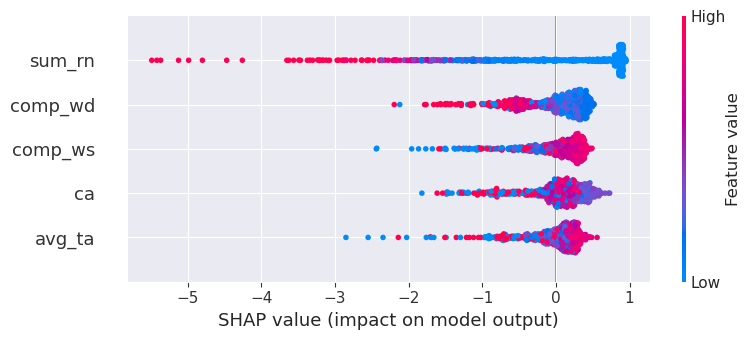

In [31]:
shap.summary_plot(shap_values, X_test)

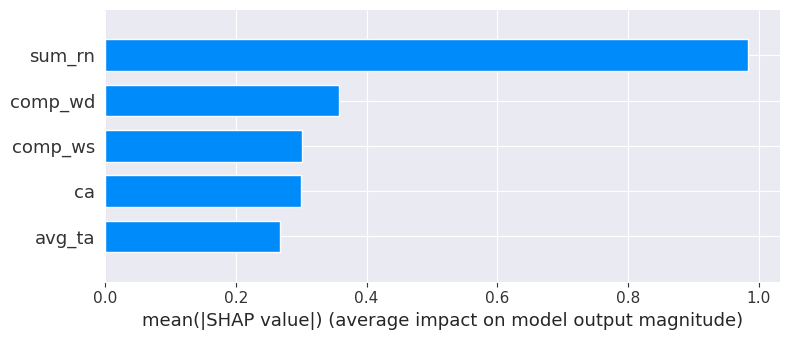

In [32]:
shap.summary_plot(shap_values, X_test, plot_type = "bar")

In [34]:
shap.force_plot(exp.expected_value, shap_values[141], features = X_test.iloc[141, : ], feature_names = X_test.columns)

In [36]:
shap.force_plot(exp.expected_value, shap_values, features = X_test, feature_names = X_test.columns)


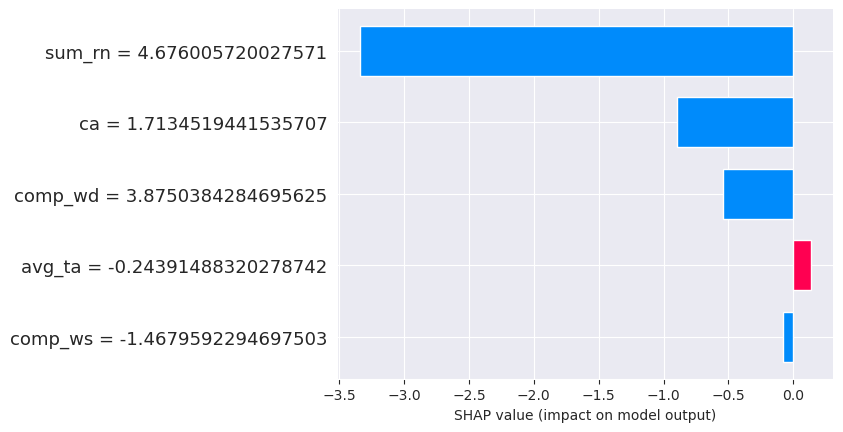

In [35]:
shap.bar_plot(shap_values[141], features = X_test.iloc[141, : ], feature_names = X_test.columns)

In [37]:
shap.bar_plot(shap_values, features = X_test, feature_names = X_test.columns)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 부산

In [79]:
X_train, X_test, y_train, y_test = train_test_split(train_Busan, train_Busan_y, test_size=0.2,stratify=train_Busan_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-12 06:20:11,999] A new study created in memory with name: no-name-8a4f4c11-6216-4007-a9f2-02082e77954f
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

Trial 5 finished with value: 0.987688098495212 and parameters: {'n_estimators': 84, 'max_samples': 0.5634217013963497, 'contamination': 0.0013686792269972348, 'max_features': 0.549842447693992, 'bootstrap': True}. Best is trial 5 with value: 0.987688098495212.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(train_Busan, train_Busan_y, test_size=0.2,stratify=train_Busan_y, random_state=1111)


In [81]:
clf = IsolationForest(n_estimators=84, max_samples=0.5634, contamination = 0.0014, max_features = 0.55, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Busan_test = clf.predict(X_test)

pred_Busan_test = pd.DataFrame(pred_Busan_test)

for i in range(len(pred_Busan_test)):
    if pred_Busan_test.iloc[i,0] == 1 :
        pred_Busan_test.iloc[i,0] = 0
    else:
        pred_Busan_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Busan_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.987688098495212


In [30]:
exp = shap.TreeExplainer(clf)
shap_values = exp.shap_values(X_test)
shap.initjs()

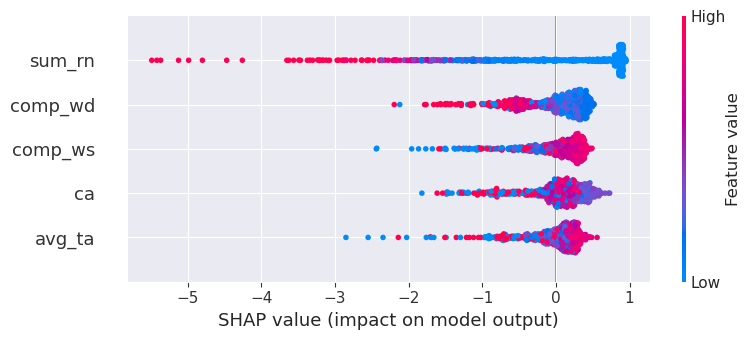

In [31]:
shap.summary_plot(shap_values, X_test)

## 서울

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_Seoul, train_Seoul_y, test_size=0.2,stratify=train_Seoul_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-15 10:27:29,653] A new study created in memory with name: no-name-a8c43d12-ab19-4df8-8904-10d474cbccba
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
X does not have valid feature names, but IsolationForest was fitted with feature names
[I 2022-11-15 10:27:30,732] Trial 0 finished with value: 0.9343365253077975 and parameters: {'n_estimators': 198, 'max_samples': 0.7219447941026265, 'contamination': 0.03779887798549307, 'max_feat

Trial 3 finished with value: 0.987688098495212 and parameters: {'n_estimators': 68, 'max_samples': 0.5712330650902631, 'contamination': 0.0020893677485190154, 'max_features': 0.6117204036845454, 'bootstrap': True}. Best is trial 3 with value: 0.987688098495212.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_Seoul, train_Seoul_y, test_size=0.2,stratify=train_Seoul_y, random_state=1111)


In [20]:
clf = IsolationForest(n_estimators=68, max_samples=0.57, contamination = 0.0021, max_features = 0.612, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Seoul_test = clf.predict(X_test)

pred_Seoul_test = pd.DataFrame(pred_Seoul_test)

for i in range(len(pred_Seoul_test)):
    if pred_Seoul_test.iloc[i,0] == 1 :
        pred_Seoul_test.iloc[i,0] = 0
    else:
        pred_Seoul_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Seoul_test,average='micro')
print('f1 score :', f1)

X does not have valid feature names, but IsolationForest was fitted with feature names


f1 score : 0.9849521203830369


In [24]:
X_train

,avg_ta,ca,sum_rn,comp_wd,comp_ws
45432,-0.432379,1.036591,0.080544,3.539635,0.251293
54323,0.591649,0.744635,0.180085,2.378934,1.868650
17212,0.467813,-1.136857,-0.278072,-1.108048,2.346645
53745,1.334664,1.652942,0.471885,1.084742,-5.243782
32733,0.105831,1.036591,-0.235906,2.628892,-1.118406
...,...,...,...,...,...
18521,-1.423066,-1.558571,-0.278072,-2.325671,-0.993158
53677,1.163199,0.387800,-0.278072,-0.572196,1.723325
35028,1.325138,-0.131232,-0.278072,-0.620886,0.770320
46469,1.134622,1.523183,-0.278072,1.791788,1.216354


In [26]:
X_train[y_train == 1]

,avg_ta,ca,sum_rn,comp_wd,comp_ws
3306,1.201303,1.296107,4.509562,1.535641,0.198178
29571,0.753588,-0.455627,-0.278072,1.539021,-0.932022
9511,1.034600,1.685381,13.214218,0.387640,1.858137
3408,1.020312,1.555623,5.961044,-0.318105,-3.548275
3850,1.258458,0.258042,0.840998,2.597320,-1.359723
15359,0.896476,1.036591,1.042150,3.113257,0.225868
9664,1.239406,1.652942,7.566925,-0.248944,-0.904540
9358,1.096518,1.652942,2.396541,0.103704,-1.372813
16311,0.967920,1.555623,0.036717,3.206673,1.609884
9477,1.086992,1.685381,1.367843,0.096535,-1.791525


In [27]:
exp = shap.TreeExplainer(clf)
shap_values = exp.shap_values(X_train[y_train == 1])
shap.initjs()

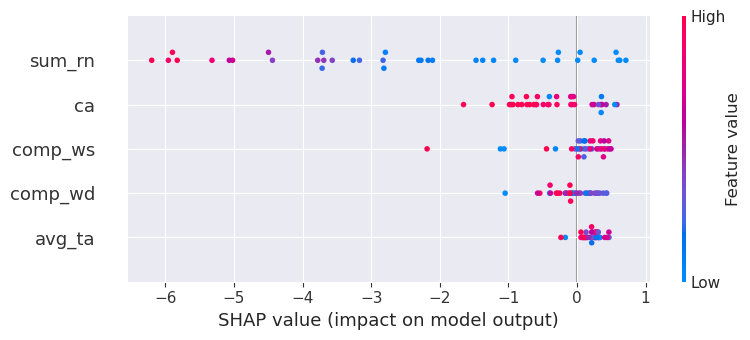

In [29]:
shap.summary_plot(shap_values, X_train[y_train == 1])

### 호우태풍데이터로 해보기 

,avg_ta,ca,sum_rn,comp_wd,comp_ws
5856,-2.051771,-1.558571,-0.278072,-1.771702,1.148924
20731,0.286822,-1.039539,-0.278072,-1.961847,-4.304110
55785,-1.284941,-1.526132,-0.278072,-1.663494,-0.360398
36116,0.039150,-0.617825,-0.278072,-1.636095,1.475199
29979,-0.460956,0.582437,-0.278072,-2.537869,-0.855016
...,...,...,...,...,...
56941,-0.856278,-0.098793,-0.278072,1.040049,1.653696
35181,0.820269,-1.266616,-0.278072,-1.271280,1.211552
51433,-0.094211,-0.942220,-0.278072,2.246262,-1.443347
15308,0.867898,1.036591,-0.273710,-0.513753,-1.638888


In [23]:
y_test

5856     0.0
20731    0.0
55785    0.0
36116    0.0
29979    0.0
        ... 
56941    0.0
35181    0.0
51433    0.0
15308    0.0
46979    0.0
Name: rain_yn, Length: 731, dtype: float64

In [21]:
exp = shap.TreeExplainer(clf)
shap_values = exp.shap_values(X_test)
shap.initjs()

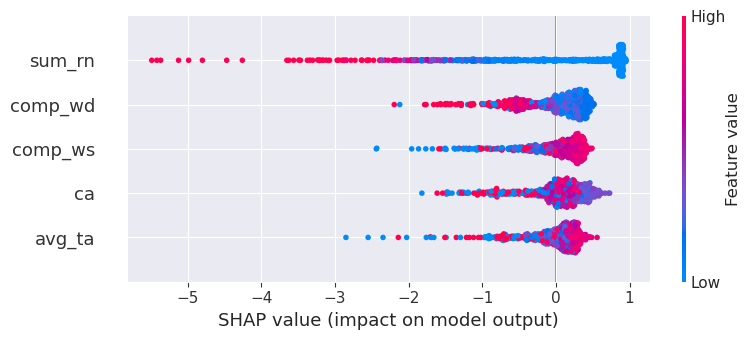

In [31]:
shap.summary_plot(shap_values, X_test)

## 경기

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Gyeonggi, train_Gyeonggi_y, test_size=0.2,stratify=train_Gyeonggi_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Gyeonggi_test = clf.predict(X_test)

pred_Gyeonggi_test = pd.DataFrame(pred_Gyeonggi_test)

for i in range(len(pred_Gyeonggi_test)):
    if pred_Gyeonggi_test.iloc[i,0] == 1 :
        pred_Gyeonggi_test.iloc[i,0] = 0
    else:
        pred_Gyeonggi_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Gyeonggi_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 경남

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Gyeongnam, train_Gyeongnam_y, test_size=0.2,stratify=train_Gyeongnam_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Gyeongnam_test = clf.predict(X_test)

pred_Gyeongnam_test = pd.DataFrame(pred_Gyeongnam_test)

for i in range(len(pred_Gyeongnam_test)):
    if pred_Gyeongnam_test.iloc[i,0] == 1 :
        pred_Gyeongnam_test.iloc[i,0] = 0
    else:
        pred_Gyeongnam_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Gyeongnam_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 경북

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Gyeongbuk, train_Gyeongbuk_y, test_size=0.2,stratify=train_Gyeongbuk_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Gyeongbuk_test = clf.predict(X_test)

pred_Gyeongbuk_test = pd.DataFrame(pred_Gyeongbuk_test)

for i in range(len(pred_Gyeongbuk_test)):
    if pred_Gyeongbuk_test.iloc[i,0] == 1 :
        pred_Gyeongbuk_test.iloc[i,0] = 0
    else:
        pred_Gyeongbuk_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Gyeongbuk_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 광주

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Gwangju, train_Gwangju_y, test_size=0.2,stratify=train_Gwangju_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Gwangju_test = clf.predict(X_test)

pred_Gwangju_test = pd.DataFrame(pred_Gwangju_test)

for i in range(len(pred_Gwangju_test)):
    if pred_Gwangju_test.iloc[i,0] == 1 :
        pred_Gwangju_test.iloc[i,0] = 0
    else:
        pred_Gwangju_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Gwangju_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 대구

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Daegu, train_Daegu_y, test_size=0.2,stratify=train_Daegu_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Daegu_test = clf.predict(X_test)

pred_Daegu_test = pd.DataFrame(pred_Daegu_test)

for i in range(len(pred_Daegu_test)):
    if pred_Daegu_test.iloc[i,0] == 1 :
        pred_Daegu_test.iloc[i,0] = 0
    else:
        pred_Daegu_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Daegu_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 대전

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Daejeon, train_Daejeon_y, test_size=0.2,stratify=train_Daejeon_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Daejeon_test = clf.predict(X_test)

pred_Daejeon_test = pd.DataFrame(pred_Daejeon_test)

for i in range(len(pred_Daejeon_test)):
    if pred_Daejeon_test.iloc[i,0] == 1 :
        pred_Daejeon_test.iloc[i,0] = 0
    else:
        pred_Daejeon_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Daejeon_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 울산

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Ulsan, train_Ulsan_y, test_size=0.2,stratify=train_Ulsan_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Ulsan_test = clf.predict(X_test)

pred_Ulsan_test = pd.DataFrame(pred_Ulsan_test)

for i in range(len(pred_Ulsan_test)):
    if pred_Ulsan_test.iloc[i,0] == 1 :
        pred_Ulsan_test.iloc[i,0] = 0
    else:
        pred_Ulsan_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Ulsan_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 인천

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Incheon, train_Incheon_y, test_size=0.2,stratify=train_Incheon_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Incheon_test = clf.predict(X_test)

pred_Incheon_test = pd.DataFrame(pred_Incheon_test)

for i in range(len(pred_Incheon_test)):
    if pred_Incheon_test.iloc[i,0] == 1 :
        pred_Incheon_test.iloc[i,0] = 0
    else:
        pred_Incheon_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Incheon_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 세종

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Sejong, train_Sejong_y, test_size=0.2,stratify=train_Sejong_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Sejong_test = clf.predict(X_test)

pred_Sejong_test = pd.DataFrame(pred_Sejong_test)

for i in range(len(pred_Sejong_test)):
    if pred_Sejong_test.iloc[i,0] == 1 :
        pred_Sejong_test.iloc[i,0] = 0
    else:
        pred_Sejong_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Sejong_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 전남

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Jeonnam, train_Jeonnam_y, test_size=0.2,stratify=train_Jeonnam_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Jeonnam_test = clf.predict(X_test)

pred_Jeonnam_test = pd.DataFrame(pred_Jeonnam_test)

for i in range(len(pred_Jeonnam_test)):
    if pred_Jeonnam_test.iloc[i,0] == 1 :
        pred_Jeonnam_test.iloc[i,0] = 0
    else:
        pred_Jeonnam_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Jeonnam_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 전북

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Jeonbuk, train_Jeonbuk_y, test_size=0.2,stratify=train_Jeonbuk_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Jeonbuk_test = clf.predict(X_test)

pred_Jeonbuk_test = pd.DataFrame(pred_Jeonbuk_test)

for i in range(len(pred_Jeonbuk_test)):
    if pred_Jeonbuk_test.iloc[i,0] == 1 :
        pred_Jeonbuk_test.iloc[i,0] = 0
    else:
        pred_Jeonbuk_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Jeonbuk_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 제주

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Jeju, train_Jeju_y, test_size=0.2,stratify=train_Jeju_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Jeju_test = clf.predict(X_test)

pred_Jeju_test = pd.DataFrame(pred_Jeju_test)

for i in range(len(pred_Jeju_test)):
    if pred_Jeju_test.iloc[i,0] == 1 :
        pred_Jeju_test.iloc[i,0] = 0
    else:
        pred_Jeju_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Jeju_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 충남

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Chungnam, train_Chungnam_y, test_size=0.2,stratify=train_Chungnam_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Chungnam_test = clf.predict(X_test)

pred_Chungnam_test = pd.DataFrame(pred_Chungnam_test)

for i in range(len(pred_Chungnam_test)):
    if pred_Chungnam_test.iloc[i,0] == 1 :
        pred_Chungnam_test.iloc[i,0] = 0
    else:
        pred_Chungnam_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Chungnam_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814


## 충북

In [47]:
X_train, X_test, y_train, y_test = train_test_split(train_Chungbuk, train_Chungbuk_y, test_size=0.2,stratify=train_Chungbuk_y, random_state=1111)
study = optuna.create_study(
        direction='maximize', 
        sampler=TPESampler())

study.optimize(objective_if,n_trials=100)

[I 2022-11-10 08:09:27,196] A new study created in memory with name: no-name-c3e4e48e-f98d-4ee2-a3fa-ee81a5fda6bf
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  # Remove th

In [48]:
clf = IsolationForest(n_estimators=132, max_samples=0.22, contamination = 0.02, max_features = 0.5, bootstrap = True, random_state=1111)
clf.fit(X_train)
#y_pred_train = clf.predict(X_train)
pred_Chungbuk_test = clf.predict(X_test)

pred_Chungbuk_test = pd.DataFrame(pred_Chungbuk_test)

for i in range(len(pred_Chungbuk_test)):
    if pred_Chungbuk_test.iloc[i,0] == 1 :
        pred_Chungbuk_test.iloc[i,0] = 0
    else:
        pred_Chungbuk_test.iloc[i,0] = 1
        
from sklearn.metrics import f1_score

f1 = f1_score(y_test, pred_Chungbuk_test,average='micro')
print('f1 score :', f1)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


f1 score : 0.931637519872814
